In [1]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt

In [2]:
stats=([0.485,0.456,0.406],[0.229,0.224,0.225])

train_transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomRotation(10),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

val_transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [3]:
train_ds=ImageFolder('/kaggle/input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Training Data',transform=train_transform)
valid_ds=ImageFolder('/kaggle/input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Prediction Data',transform=val_transform)

len(train_ds),len(valid_ds)

(10000, 1306)

In [5]:
classes=train_ds.classes
classes

['Bald Uakari',
 'Emperor Tamarin',
 'Golden Monkey',
 'Gray Langur',
 'Hamadryas Baboon',
 'Mandril',
 'Proboscis Monkey',
 'Red Howler',
 'Vervet Monkey',
 'White Faced Saki']

In [6]:
def denormalize(images,means,stds): 
    if len(images.shape)==3:
        images=images.unsqueeze(0)
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_image(img_tensor,label):
    print('Label: ',classes[label],'('+str(label)+')')
    img_tensor=denormalize(img_tensor,*stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

Label:  Bald Uakari (0)


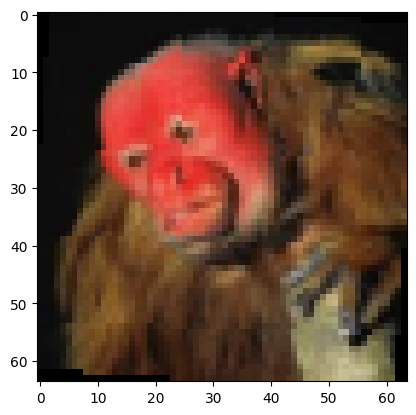

In [7]:
img,label=train_ds[10]
show_image(img,label)

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        return len(self.dl)

In [9]:
device=get_default_device()
device

device(type='cuda')

In [22]:
train_dl=DataLoader(train_ds,batch_size=128,shuffle=True,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size=128,shuffle=False,pin_memory=True)

train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)  
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        lr = result.get('lr', [0.0])
        train_loss = result.get('train_loss', 0.0)
        val_loss = result.get('val_loss', 0.0)
        val_acc = result.get('val_acc', 0.0)
        train_acc = result.get('train_acc', 0.0)  

        if isinstance(lr, list):
            lr = lr[-1]

        print(f"Epoch [{epoch}], "
              f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [12]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class MonkeySpecies(ImageClassificationBase):
    
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.conv1=conv_block(in_channels,64)
        self.conv2=conv_block(64,128,pool=True)
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier=nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                     nn.Flatten(),
                                     nn.Dropout(0.2),
                                     nn.Linear(512,num_classes))
        
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out

In [13]:
import torch.optim as optim

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []  
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch) 
            train_losses.append(loss)
            train_accs.append(acc)  
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()  
        result['lr'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
            
    return history

In [23]:
model=to_device(MonkeySpecies(3,len(classes)),device)
model

MonkeySpecies(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [24]:
for batch in train_dl:
    images,labels=batch
    print('images.shape',images.shape)
    print('images.device',images.device)
    preds=model(images)
    print('preds.shape',preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 10])


In [25]:
history=[evaluate(model,valid_dl)]
history

[{'val_loss': 2.3289902210235596, 'val_acc': 0.07741477340459824}]

In [26]:
history+=fit_one_cycle(30,0.001,model,train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], train_loss: 2.0476, train_acc: 0.3434, val_loss: 1.4325, val_acc: 0.5241
Epoch [1], train_loss: 1.3348, train_acc: 0.5568, val_loss: 0.9659, val_acc: 0.7020
Epoch [2], train_loss: 1.0592, train_acc: 0.6585, val_loss: 0.9375, val_acc: 0.7079
Epoch [3], train_loss: 0.8940, train_acc: 0.7064, val_loss: 0.7642, val_acc: 0.7397
Epoch [4], train_loss: 0.7987, train_acc: 0.7366, val_loss: 0.7028, val_acc: 0.7617
Epoch [5], train_loss: 0.7324, train_acc: 0.7682, val_loss: 1.0147, val_acc: 0.6837
Epoch [6], train_loss: 0.6514, train_acc: 0.7906, val_loss: 0.8093, val_acc: 0.7553
Epoch [7], train_loss: 0.6223, train_acc: 0.8075, val_loss: 0.9689, val_acc: 0.6936
Epoch [8], train_loss: 0.5650, train_acc: 0.8219, val_loss: 0.7454, val_acc: 0.7675
Epoch [9], train_loss: 0.5120, train_acc: 0.8362, val_loss: 0.4829, val_acc: 0.8433
Epoch [10], train_loss: 0.4566, train_acc: 0.8576, val_loss: 0.5606, val_acc: 0.8327
Epoch [11], train_loss: 0.4237, train_acc: 0.8664, val_loss: 0.6013, val_ac

In [20]:
def plot_accuracies(history):
    accuracies=[x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('acc vs epoch')

def plot_losses(history):
    train_losses=[x.get('train_loss') for x in history]
    val_losses=[x['val_loss'] for x in history]
    plt.plot(train_losses,'-bx')
    plt.plot(val_losses,'-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train','valid'])
    plt.title('loss vs epoch')
    
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

def predict(index, dataset, model, classes):
    img, label = dataset[index]
    show_image(img, label)
    pred = predict_image(img, model, classes)
    print('Predicted: ', pred)

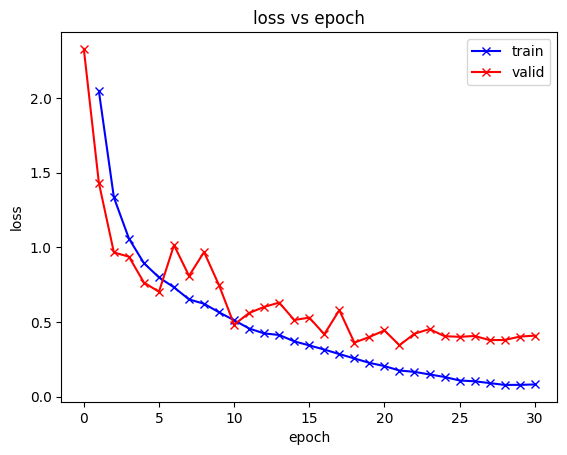

In [27]:
plot_losses(history)

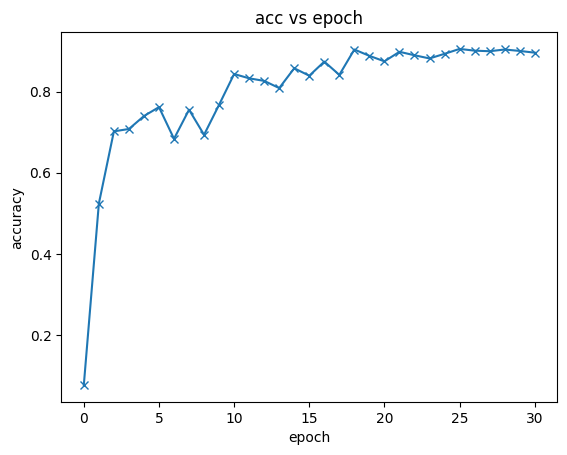

In [28]:
plot_accuracies(history)

Label:  Bald Uakari (0)
Predicted:  Bald Uakari


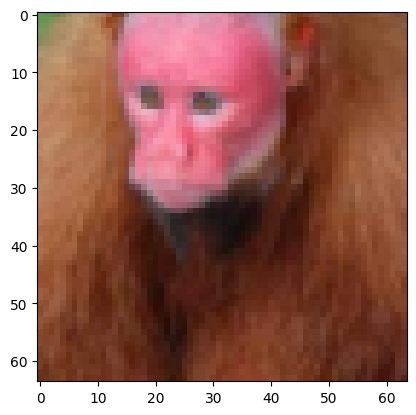

In [29]:
predict(10,valid_ds,model,classes)

Label:  Golden Monkey (2)
Predicted:  Golden Monkey


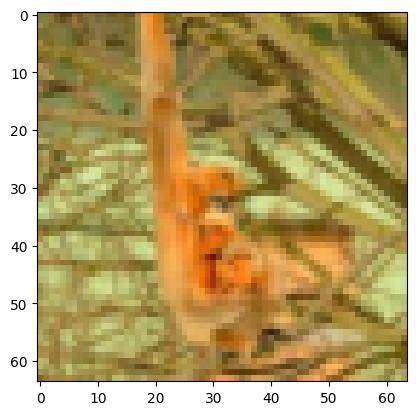

In [30]:
predict(200,valid_ds,model,classes)

Label:  Gray Langur (3)
Predicted:  Gray Langur


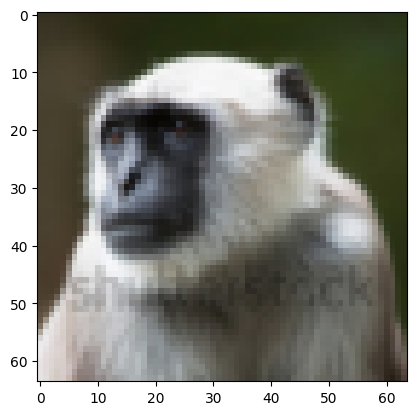

In [31]:
predict(300,valid_ds,model,classes)

Label:  Bald Uakari (0)
Predicted:  Bald Uakari


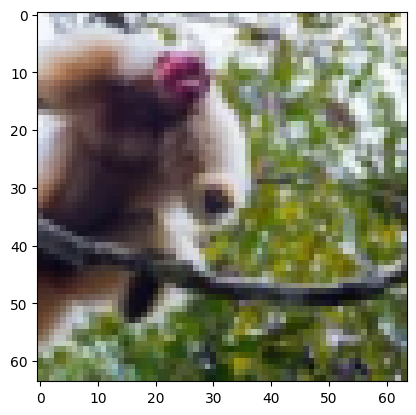

In [32]:
predict(3,valid_ds,model,classes)